In [1]:
#############################################################################################################################################
#
# Stock future performance classification based on text
#
# Approach:
#
# Build on top of it a 1D convolutional neural network, ending in a softmax output over 3 even categories.
# Use word Glove word vectors for large English text corpus as inputs model
#
# Steps
# 1) After cleaning, we convert all text samples in the dataset into sequences of word indices.  In this case, a "word index" would simply be an integer ID for the word. 
# 2) We consider the top 350,000 most commonly occuring words in the dataset
# 3) We truncate the sequences to a maximum length of 25,000 words.
# 5) We [repare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.
# 6) Then, we load this embedding matrix into a Keras Embedding layer, set to be frozen (its weights, the embedding vectors, will not be updated during training).
#
###############################################################################################################################################

# import libraries
from __future__ import print_function
import numpy as np
from six.moves import zip
import json
import warnings
import pandas as pd
from pandas import DataFrame   
import pickle
import re
import sys 
import azureml
import string
from scipy import stats
import pip
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer     
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers.core import Dropout
from keras.layers import LSTM
from keras.layers import Dense, Input, Flatten 
from keras.layers import Conv1D, MaxPooling1D, Embedding 
from keras.models import Model 
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.applications import imagenet_utils
from keras.layers import Embedding
from keras.utils.np_utils import to_categorical
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
import keras.backend as K
import os
import tempfile  
import logging
import gensim
from gensim.models import Phrases, phrases
from gensim.models.phrases import Phraser
from gensim.models import Word2Vec as wv
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
from IPython.display import SVG
import cloudpickle
import csv
import mkl
import matplotlib.pyplot as plt
import h5py
from keras.models import load_model
import re
import io
from os.path import dirname, join
import regex
import graphviz
import pydotplus
import pyparsing
from keras.utils import plot_model




Using Theano backend.
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

##########################################
# Get Previously Organized Stock Data
##########################################

os.chdir('C:\\users\\pattyry\\documents\\AzureML\\NextAgenda_CodeStory\\NextAgenda_CodeStory')

with open('biotechcleaned.pkl', 'rb') as f:
    data = pickle.load(f, encoding='utf8')
    print("Data unpickled")
data = pd.DataFrame(data)
thedata = data

np.random.seed(1337)  # for reproducibility
#################################
#If necessary, convert categories
#################################
#thedata['ReturnQuantile'] = thedata['ReturnQuantile'].map({0:0,1:1,2:1,3:1,4:2})
print('Review the unique labels',thedata['Return3Bin_4Weeks'].unique())

##########################################
# clean up the text in the data with regex
##########################################
#Most clean up already done in pre-processing script in a jupyter notebook.
thedata['fulltext'] = thedata['fulltext'].str.encode('utf-8')
thedata['fulltext'] = thedata['fulltext'].str.lower()

def clean_text(row):
    text = str(row['fulltext'])

    # Remove newline characters
    cleantext = text.replace('\r\n', ' ')

    # Convert HTML punctuation chaaracters
    cleantext = cleantext.replace('.', '')

    #remove non alpha characters and specific noise
    #cleantext = re.sub(r'\d+', '',cleantext)
    cleantext = re.sub(r'^b','',cleantext)
    cleantext = re.sub(r'[^\w]',' ',cleantext)

    #remove specific noise
    cleantext = cleantext.translate(str.maketrans({'‘':' ','’':' '}))
    cleantext = cleantext.translate(str.maketrans({',':' ',',':' '}))
    cleantext = cleantext.translate(str.maketrans({'"':' ','%':' '}))

    #remove punctuation
    punctpattern = re.compile('[%s]' % re.escape(string.punctuation))
    cleanttext = re.sub(punctpattern,'', cleantext)

    #remove single letter word
    cleantext = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', cleantext) 

    # Remove extra spaces
    cleantext = re.sub('\s+', ' ', cleantext).strip()

    return cleantext

#apply regex fixes to the input text column
thedata['CleanText'] = thedata.apply(clean_text, axis=1)
justcleandocs=thedata.drop(['fulltext'], axis=1)

#save a cleaned copy to inspect
justcleandocs.to_csv('C:\\glove\cleaneddata2.tsv', sep='\t', encoding='utf-8')
print(justcleandocs.shape)
justcleandocs.head(2)

Data unpickled
Review the unique labels [0, 2, 1]
Categories (3, int64): [0 < 1 < 2]
(916, 3)


,count,Return3Bin_4Weeks,CleanText
131,72955,0,acad overview we are biopharmaceutical company...
133,74741,2,acad company overview we are biopharmaceutical...


In [3]:


################################
# Convert labels to categorical
################################

justcleandocs=thedata.drop(['fulltext','Return3Bin_4Weeks'], axis=1)
justcleandocs = justcleandocs['CleanText']
print('post regex justcleandocs',justcleandocs.head(10))

justlabels=thedata.drop(['fulltext','CleanText'], axis=1)
justlabels=pd.DataFrame(justlabels['Return3Bin_4Weeks'])
print('head of just labels',justlabels.head(5))
print(justlabels.head())
print(justlabels.tail())
print(justlabels['Return3Bin_4Weeks'].unique())


###################################################
# Set Global Vars
####################################################

MAX_SEQUENCE_LENGTH = 10000
MAX_NB_WORDS = 400000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
LEARNING_RATE = .00011
BATCH_SIZE = 32
DROPOUT_RATE = 0.45
INNERLAYER_DROPOUT_RATE = 0.15
np.random.seed(2032)

#change directory to write results
os.chdir('C:\\')
BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove/'



post regex justcleandocs 131    acad overview we are biopharmaceutical company...
133    acad company overview we are biopharmaceutical...
134    acad company overview we are biopharmaceutical...
135    acad company overview we are biopharmaceutical...
136    acad overview we are biopharmaceutical company...
137    acad overview we are biopharmaceutical company...
138    acad overview we are biopharmaceutical company...
139    acad overview we are biopharmaceutical company...
140    acad overview we are biopharmaceutical company...
181    achn overview we are biopharmaceutical company...
Name: CleanText, dtype: object
head of just labels     Return3Bin_4Weeks
131                 0
133                 2
134                 0
135                 0
136                 2
    Return3Bin_4Weeks
131                 0
133                 2
134                 0
135                 0
136                 2
      Return3Bin_4Weeks
65850                 0
65851                 1
65852             

In [4]:

######################################################
# Format our text samples and labels for use in Keras
######################################################
# Then we can format our text samples and labels into tensors that can be fed into a neural network. 
# Here we tokenize our source 'justcleandocs'
# note that the values here are ultimately indexes to the actual words

#convert text format
justcleandocslist  = justcleandocs.values
justcleandocslist[6]
labels  = justlabels.values
labels_index = {}
#labels_index =  {0:0,1:1,2:2,3:3,4:4}
labels_index =  {0:0,1:1,2:2}
print('labels_index', labels_index)

#tokenize the text
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(justcleandocslist) #tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(justcleandocslist) #sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index #word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))
#print('sequences first', sequences[0])

#Pad sequences so that they all have the same length in a batch of input data 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre')
sequences = None
texts = None


##################################################
#build label array from target y label in data set
##################################################
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
X_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('length of y_val',len(y_val))
print('shape of y_val',y_val.shape)
print('length of X_val',len(X_val))
print('shape of X_val',X_val.shape)

os.chdir('C:\\glove\\nextagenda')

#from itertools import islice
#head = list(islice(y_val, 6))
#print('head of yval',head)



#####################################
# Save Validation Set for Evaluation
####################################
np.savetxt('y_val_3bin.txt', y_val, delimiter=',')
np.savetxt('X_val_3bin.txt', X_val,  fmt='%s', delimiter=',')
print('test and training sets saved to disk for later evaluation')

labels_index {0: 0, 1: 1, 2: 2}
Found 23887 unique tokens
Shape of data tensor:  (916, 10000)
Shape of label tensor:  (916, 3)
length of y_val 183
shape of y_val (183, 3)
length of X_val 183
shape of X_val (183, 10000)
test and training sets saved to disk for later evaluation


In [5]:

########################################
# Preparing the embedding layer
########################################

#load in word vectors from glove reference global English data set
# https://nlp.stanford.edu/projects/glove/
# see more reference links at bottom

print('Loading word vectors to prepare the embedding layer...')
print(os.getcwd())

embeddings_index = {}
print('Loading Glove Model...')
gloveFile = 'C:\\glove\\glove6B300d.txt'
words = pd.read_table(gloveFile, sep=" ", header=None, quoting=csv.QUOTE_NONE)

print(words.head(5))
print('shape of glove model',words.shape)

wordkeys=words.iloc[:,0]
print('wordkeys type of file', type(wordkeys))
words2 = words.rename(columns={ words.columns[0]: "words" })
words2['words'].apply(str)
#print(words2.dtypes)

embeddings_index = words2.set_index('words').T.to_dict('list')

#print(dict(list(embeddings_index.items())[0:2]))
print('Found {} word vectors.'.format(len(embeddings_index)))
#usage of pandas function dataFrame.to_dict(outtype='dict') outtype : str {‘dict’, ‘list’, ‘series’}


#################################
#Build the embedding matrix
#################################

print('Building Embedding Matrix...')
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


Loading word vectors to prepare the embedding layer...
C:\glove\nextagenda
Loading Glove Model...
   0         1         2         3         4         5         6         7    \
0  the  0.046560  0.213180 -0.007436 -0.458540 -0.035639  0.236430 -0.288360   
1    , -0.255390 -0.257230  0.131690 -0.042688  0.218170 -0.022702 -0.178540   
2    . -0.125590  0.013630  0.103060 -0.101230  0.098128  0.136270 -0.107210   
3   of -0.076947 -0.021211  0.212710 -0.722320 -0.139880 -0.122340 -0.175210   
4   to -0.257560 -0.057132 -0.671900 -0.380820 -0.364210 -0.082155 -0.010955   

        8         9      ...          291       292       293       294  \
0  0.215210 -0.134860    ...    -0.013064 -0.296860 -0.079913  0.195000   
1  0.107560  0.058936    ...     0.075968 -0.014359 -0.073794  0.221760   
2  0.236970  0.328700    ...     0.060148 -0.156190 -0.119490  0.234450   
3  0.121370 -0.070866    ...    -0.366730 -0.386030  0.302900  0.015747   
4 -0.082047  0.460560    ...    -0.012806 -0.5

In [6]:

##############################################
#Training a 1D convnet
##############################################

print('Train 1D Convnet with global maxpooling')
print('Shape of training data sample tensor: ', X_train.shape)
print('Shape of training label tensor: ', y_train.shape)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')


embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(INNERLAYER_DROPOUT_RATE)(x)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(INNERLAYER_DROPOUT_RATE)(x)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(35)(x)  # global max pooling

x = Flatten()(x)
x = Dense(100, activation='elu', kernel_initializer='lecun_uniform')(x) # best initializers: #glorot_normal #VarianceScaling #lecun_uniform
x = Dropout(DROPOUT_RATE)(x)

preds = Dense(len(labels_index), activation='softmax')(x) #no initialization in output layer


model = Model(sequence_input, preds)


Train 1D Convnet with global maxpooling
Shape of training data sample tensor:  (733, 10000)
Shape of training label tensor:  (733, 3)


Train on 733 samples, validate on 183 samples
Epoch 1/24
733/733 [==============================] - 330s - loss: 1.2609 - acc: 0.3302 - val_loss: 1.1046 - val_acc: 0.3497
Epoch 2/24
733/733 [==============================] - 293s - loss: 1.1536 - acc: 0.3834 - val_loss: 1.0895 - val_acc: 0.4153
Epoch 3/24
733/733 [==============================] - 288s - loss: 1.1175 - acc: 0.3874 - val_loss: 1.0802 - val_acc: 0.3607
Epoch 4/24
733/733 [==============================] - 324s - loss: 1.0857 - acc: 0.4120 - val_loss: 1.0744 - val_acc: 0.3825
Epoch 5/24
733/733 [==============================] - 331s - loss: 1.0675 - acc: 0.4256 - val_loss: 1.0710 - val_acc: 0.3934
Epoch 6/24
733/733 [==============================] - 338s - loss: 1.0693 - acc: 0.4338 - val_loss: 1.0857 - val_acc: 0.4153
Epoch 7/24
733/733 [==============================] - 331s - loss: 1.0571 - acc: 0.4447 - val_loss: 1.0910 - val_acc: 0.3825
Epoch 8/24
733/733 [==============================] - 320s - loss: 1.0301 - acc

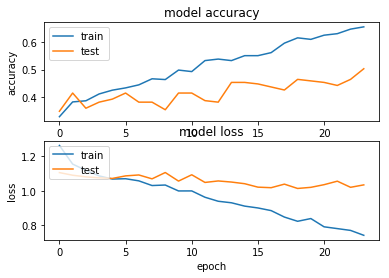

In [7]:
################################
#Compile model, set optimizers
################################ 

adam = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipvalue=0.5)#, clipnorm=1.)
rmsprop = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=1e-08, decay=0.00)

model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])
from keras.callbacks import History 
history = History()

early_stopping = EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=24,
          validation_data=(X_val, y_val), callbacks=[early_stopping, history])


##############################
# Save Model and Plots
##############################
model.save('C:\\glove\\StockText_3Level3EvenClass_modelNov2_8pm.h5')
 
import matplotlib.pyplot as plt  
plt.figure(1)  

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

#plot_model(model, to_file='C:\\glove\stocktext_model3class.png')

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

##############################
# More helpful links
##############################

#We can also test how well we would have performed by not using pre-trained word embeddings, 
#but instead initializing our Embedding layer from scratch and learning its weights during training. 

#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#https://arxiv.org/abs/1603.03827 
#https://nlp.stanford.edu/projects/glove/ 
#https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
#https://stackoverflow.com/questions/27139908/load-precomputed-vectors-gensim?rq=1
#https://stackoverflow.com/questions/14415741/numpy-array-vs-asarray